In [216]:
# Import python packages
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from uszipcode import SearchEngine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Business Features

In [217]:
# Read business data and checkin data
business = pd.read_csv('clean_business.csv')
business.shape

(7116, 13)

In [218]:
# Reveal first few rows 
business.head()

,attributes,business_id,categories,city,latitude,longitude,name,postal_code,review_count,stars,state,isBankrupt,county
0,"{'RestaurantsTableService': False, 'GoodForMea...",rDMptJYWtnMhpQu_rRXHng,"['Fast Food', 'Burgers', 'Restaurants']",Phoenix,33.607070,-112.064382,McDonald's,85022,10,1.0,AZ,0,Maricopa County
1,"{'RestaurantsTableService': True, 'GoodForMeal...",1WBkAuQg81kokZIPMpn9Zg,"['Burgers', 'Restaurants']",Phoenix,33.607310,-112.063404,Charr An American Burger Bar,85022,232,3.0,AZ,0,Maricopa County
2,"{'RestaurantsTableService': False, 'GoodForMea...",iPa__LOhse-hobC2Xmp-Kw,"['Restaurants', 'Burgers', 'Fast Food']",Phoenix,33.508765,-112.046240,McDonald's,85016,34,3.0,AZ,0,Maricopa County
3,"{'BusinessAcceptsCreditCards': True, 'Business...",YhV93k9uiMdr3FlV4FHjwA,"['Marketing', ""Men's Clothing"", 'Restaurants',...",Phoenix,33.449967,-112.070222,Caviness Studio,85001,4,5.0,AZ,0,Maricopa County
4,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",VdlPZg2NAu8t8GkdbPLecg,"['Restaurants', 'Gluten-Free', 'Indian', 'Seaf...",Scottsdale,33.555212,-111.900456,Tandoori Times Indian Bistro,85258,263,3.5,AZ,0,Maricopa County


In [219]:
# Make a copy of raw dataset
business_df = business.copy()

## Create isChain

In [5]:
# Create new feature chain
dict_chain = business_df['name'].value_counts().to_dict()
business_df['isChain'] = business_df['name'].apply(lambda x: int(dict_chain[x] > 1))

## Create City Density

In [6]:
# Create a dictionary to store restuarant number in each city
city_dict = business_df.groupby('city').apply(len).to_dict()

# Create new feature neighborhood_city
business_df['density'] = business_df['city'].apply(lambda city: city_dict.get(city))

## Create Neighborhood Density

In [7]:
# Use Kmeans Clustering to identify grouping by latitude and longitude
def geocluster(data, k_min=2, k_max=2, step=1):
    coordinates = data[['latitude', 'longitude']].copy()
    
    # Compute Silhouette scores for each K
    silhouette = []
    k_range = list(range(k_min, k_max+step, step))
    for i in k_range:
        kmeans = KMeans(n_clusters=i, random_state=314).fit(coordinates)
        silhouette.append(silhouette_score(coordinates, kmeans.labels_, metric='euclidean'))
        
    return pd.DataFrame(dict(k=k_range, silhouette_score=silhouette))

In [8]:
%%time
# Compute silhouette score for different K's
silhouette_result = geocluster(business_df, 20, 1000, 20)
silhouette_result.head();

Wall time: 6min 49s


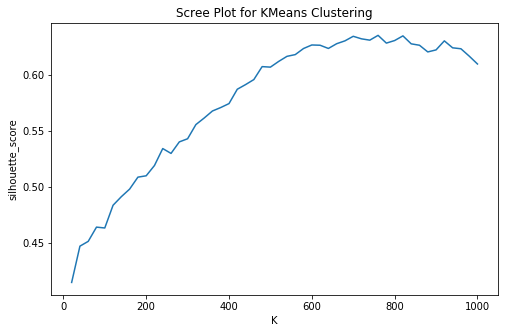

In [9]:
# Plot the silhouette for different K's
plt.figure(figsize=(8,5))
plt.plot(silhouette_result['k'], silhouette_result['silhouette_score'])
plt.xlabel('K')
plt.ylabel('silhouette_score')
plt.title('Scree Plot for KMeans Clustering');

In [10]:
# Get the best number of cluseter K
best_k = silhouette_result['k'][silhouette_result['silhouette_score'].idxmax()]
best_k

760

In [11]:
# Fit Kmeans Model to the coordinates
kmeans = KMeans(n_clusters=best_k, random_state=314).fit(business_df[['latitude', 'longitude']].copy())

# Add the cluster labels to data
business_df['cluster'] = kmeans.labels_

In [256]:
# Calculate number of restaurants in each centroid
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude']) \
                .reset_index() \
                .rename(columns={'index':'k'})
centroids['size'] = business_df.groupby('cluster').size()
centroids.head()

,k,latitude,longitude,size
0,0,33.378323,-112.030133,19
1,1,33.538795,-112.183971,26
2,2,33.378500,-111.786990,26
3,3,33.624828,-111.923824,28
4,4,33.484423,-112.363563,8


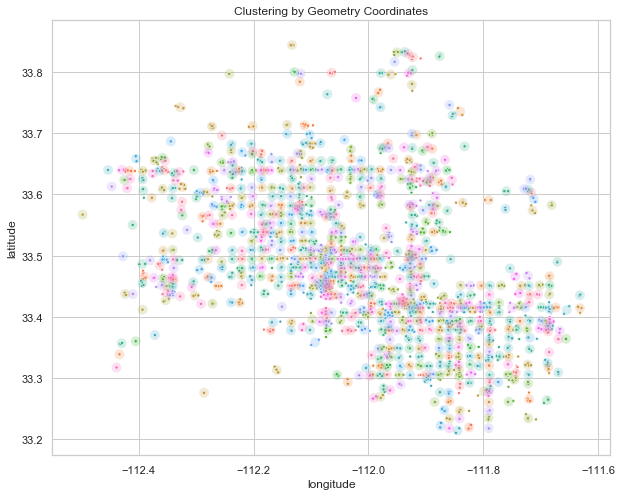

In [265]:
# Visualize the geometry clustering
plt.figure(figsize=(10,8))
cmap=sns.husl_palette(n_colors=best_k)
sns.scatterplot('longitude', 'latitude', hue='cluster', data=business_df, legend=False, s=10, palette=cmap)
sns.scatterplot('longitude', 'latitude', hue='k', data=centroids, legend=False, s=100, alpha=0.2, palette=cmap)
plt.title('Clustering by Geometry Coordinates');

In [164]:
# Compute neighborhood density for each cluster
neighborhood = centroids.set_index('k')['size'].to_dict()
business_df['neighborhood'] = business_df['cluster'].apply(lambda row: neighborhood[row])

## Parse String

In [290]:
# Convert types of attributes and categories to dictionary and list
business_df['attributes'] = business_df['attributes'].apply(lambda x: eval(x))
business_df['categories'] = business_df['categories'].apply(lambda x: eval(x))

## Extract Categories Features

In [291]:
# Extract all words in categories
categories = np.unique([item for row in business_df['categories'] for item in row])
len(categories)

417

## Restaurant Ethnicity

In [ ]:
ethnics = ['Afghan', 'African', 'American (New)', 'American (Traditional)', 'Arabian', 'Argentine',
           'Armenian', 'Asian Fusion', 'Australian', 'Austrian', 'Belgian', 'Brazilian', 'British',
           'Cajun/Creole', 'Cambodian', 'Cantonese', 'Caribbean', 'Chinese', 'Colombian', 'Indian',
           'Cuban', 'Czech', 'Dominican', 'Empanadas', 'Ethiopian', 'Filipino', 'French', 'German', 'Greek',
           'Hawaiian', 'Irish', 'Italian', 'Japanese', 'Korean', 'Kosher', 'Halal', 'Laotian', 'Latin American',
           'Lebanese', 'Malaysian', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Modern European', 'Mongolian',
           'Moroccan', 'Pakistani', 'Persian/Iranian', 'Peruvian', 'Puerto Rican', 'Russian', 'Salvadoran',
           'Scandinavian', 'Southern', 'Spanish', 'Szechuan', 'Taiwanese', 'Thai', 'Tex-Mex', 'Trinidadian',
           'Vietnamese', 'Turkish', 'Ukrainian', 'Uzbek']

In [295]:
# Create new feature ethnics
business_df['ethnics'] = business_df['categories'].apply(lambda row: [x for x in row if x in ethnics])
business_df['ethnics'].value_counts().head()

[]                          2668
[Mexican]                    904
[American (Traditional)]     717
[Italian]                    497
[American (New)]             419
Name: ethnics, dtype: int64

In [296]:
# Create a dictionary to store the appear times of each ethnics
ethnics_dist = dict(zip(ethnics, [sum([(x in row) for row in business_df['ethnics']]) for x in ethnics]))
len(ethnics_dist)

64

In [297]:
# Convert dictionary to dataframe
ethnics_df = pd.DataFrame(list(ethnics_dist.items()), columns=['Ethnics','Count']) \
                .sort_values('Count',ascending = False) \
                .reset_index() \
                .drop('index', axis=1)
ethnics_df.head()

,Ethnics,Count
0,Mexican,1152
1,American (Traditional),1048
2,American (New),727
3,Italian,555
4,Chinese,435


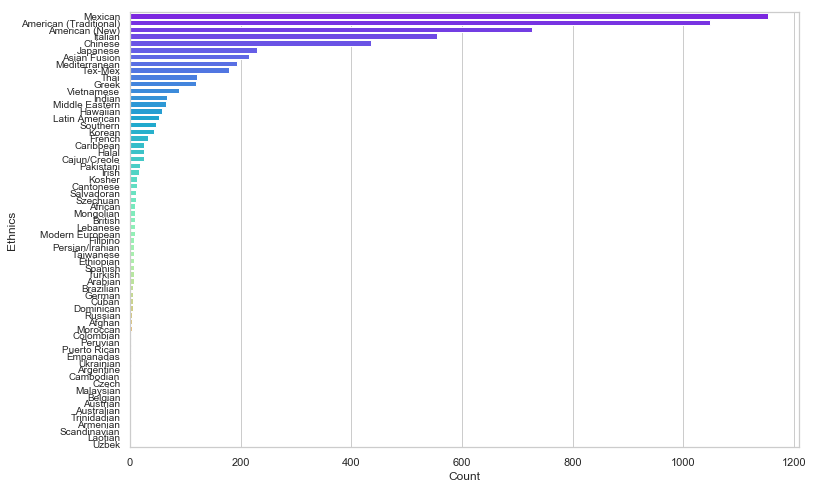

In [298]:
# Visualize top 10 ethnics
plt.figure(figsize=(12,8))
sns.set(style='whitegrid')
ethnics_plot = sns.barplot(x='Count', y='Ethnics', data=ethnics_df, palette ='rainbow')
ethnics_plot.set_yticklabels(ethnics_plot.get_yticklabels(), fontdict={'fontsize':10});

In [299]:
# Combine ethnics into fewer categories
ethnic_dict = {
    'MiddleEast': ['Arabian', 'Armenian', 'Halal','Lebanese','Middle Eastern','Turkish','Mediterranean',
                  'Afghan','Pakistani','Persian/Iranian'],
    'African': ['African', 'Ethiopian', 'Moroccan'],
    'American': ['American (New)', 'American (Traditional)','Hawaiian','Southern'],
    'European': ['Austrian', 'Belgian', 'British', 'Czech','French','German','Greek','Irish','Italian',
                   'Kosher','Modern European','Cajun/Creole','Scandinavian','Spanish','Australian'],
    'Chinese': ['Cantonese', 'Chinese','Szechuan','Taiwanese'],
    'LatinAmerica': ['Argentine', 'Brazilian', 'Caribbean', 'Colombian', 'Cuban', 'Dominican', 'Empanadas',
                         'Latin American', 'Peruvian', 'Puerto Rican', 'Salvadoran', 'Trinidadian'],
    'SouthEastAsia': ['Cambodian', 'Filipino','Laotian', 'Malaysian', 'Thai', 'Vietnamese','Indian'],
    'EastAsia': ['Japanese', 'Korean', 'Asian Fusion'],
    'Mexican': ['Mexican','Tex-Mex'],
    'AsiaContinent': ['Mongolian','Russian','Ukrainian','Uzbek']
}

In [300]:
# Merge ethnics into smaller categories
merge_ethnic = lambda row: np.unique([ethnic if x in ethnic_dict[ethnic] else x for x in row])
for ethnic in ethnic_dict.keys():
    business_df['ethnics'] = business_df['ethnics'].apply(merge_ethnic)

In [301]:
# Update the dictionary
ethnics = ethnic_dict.keys()
ethnics_dict = dict(zip(ethnics, [sum([(x in row) for row in business_df['ethnics'] if len(row) > 0]) for x in ethnics]))
len(ethnics_dict)

10

In [302]:
# Convert dictionary to dataframe
ethnics_df = pd.DataFrame(list(ethnics_dict.items()), columns=['Ethnics','Count']) \
                .sort_values('Count',ascending = False) \
                .reset_index() \
                .drop('index', axis=1)

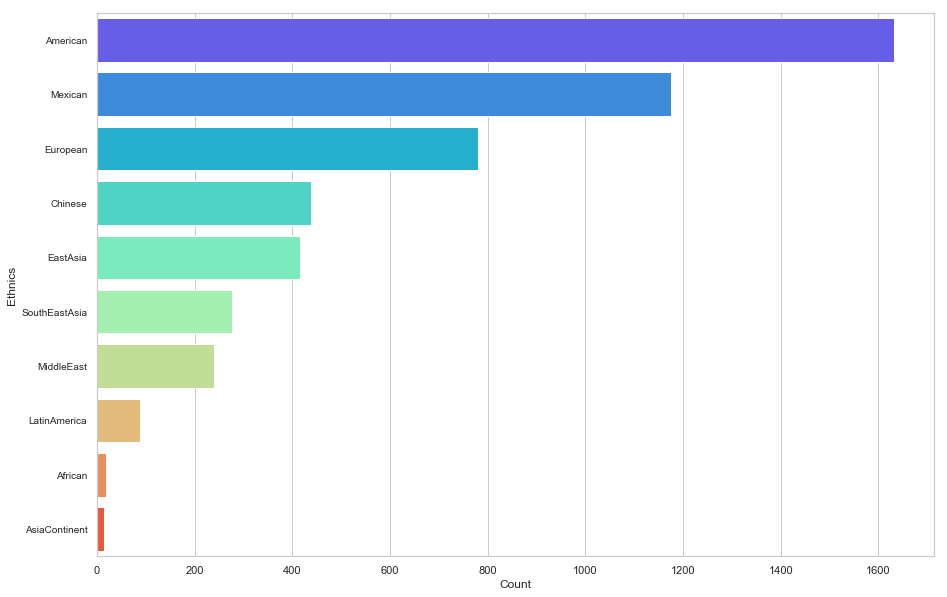

In [303]:
# Visualize dataframe ethnics
plt.figure(figsize=(15,10))
sns.set(style = 'whitegrid')
ethnics_plot = sns.barplot(x='Count', y='Ethnics', data=ethnics_df, palette ='rainbow')
ethnics_plot.set_yticklabels(ethnics_plot.get_yticklabels(), fontdict={'fontsize':10});

## Food Types

In [ ]:
types = ['Acai Bowls', 'Bagels', 'Bubble Tea', 'Burgers', 'Cheesesteaks', 'Chicken Wings', 'Creperies','Cupcakes',
         'Custom Cakes', 'Do-It-Yourself Food', 'Donuts', 'Falafel', 'Fish & Chips', 'Fondue', 'Fruits & Veggies',
         'Gelato','Gluten-Free', 'Hot Dogs', 'Hot Pot', 'Ice Cream & Frozen Yogurt', 'Imported Food',
         'Juice Bars & Smoothies', 'Kebab', 'Live/Raw Food','Local Flavor', 'Macarons','Noodles',
         'Pita', 'Pizza', 'Poutineries', 'Sandwiches', 'Pretzels', 'Ramen', 'Rotisserie Chicken','Salad',
         'Seafood', 'Shaved Ice', 'Shaved Snow', 'Soup', 'Tacos', 'Teppanyaki',
         'Waffles', 'Wraps', 'Bakeries', 'Barbeque', 'Beverage Store', 'Buffets', 'Cafes',
         'Cafeteria', 'Candy Stores', 'Caterers', 'Cheese Shops', 'Chicken Shop', 'Chocolatiers & Shops',
         'Coffee & Tea', 'Coffee & Tea Supplies', 'Coffee Roasteries', 'Coffeeshops','Desserts',
         'Dim Sum', 'Delis', 'Fast Food', 'Food Court', 'Food Stands', 'Food Trucks', 'Hotels',
         'Hotels & Travel', 'Internet Cafes', 'New Mexican Cuisine',
         'Organic Stores', 'Pan Asian', 'Pasta Shops', 'Patisserie/Cake Shop', 'Popcorn Shops', 'Seafood Markets',
         'Steakhouses', 'Sushi Bars', 'Tea Rooms', 'Themed Cafes', 'Vegan', 'Vegetarian',
         'Bars', 'Beer', 'Beer Bar', 'Beer Gardens', 'Brasseries', 'Breweries', 'Brewpubs', 'Champagne Bars',
         'Cocktail Bars', 'Distilleries', 'Dive Bars', 'Gay Bars', 'Gastropubs','Hotel bar', 'Izakaya','Irish Pub',
         'Piano Bars', 'Pubs', 'Speakeasies','Sports Bars','Tapas Bars', 'Whiskey Bars', 'Wine & Spirits','Wine Bars',
         'Wineries']

In [305]:
# Create new feature types
business_df['types'] = business_df['categories'].apply(lambda row: [x for x in row if x in types])

In [306]:
# Create a dictionary to store the appear times of each types
types_dist = dict(zip(types, [sum([x in row for row in business_df['types']]) for x in types]))
len(types_dist)

106

In [307]:
type_dict = {
    'Fast Food': ['Burgers','Fish & Chips','Hot Dogs','Sandwiches','Fast Food'],
    'Alcohol': ['Bars','Beer', 'Beer Bar','Beer Gardens','Brasseries', 'Breweries', 'Brewpubs','Champagne Bars',
                'Cocktail Bars','Distilleries','Dive Bars','Gay Bars', 'Gastropubs','Hotel bar','Izakaya',
                'Irish Pub','Piano Bars', 'Pubs','Speakeasies','Sports Bars','Tapas Bars','Whiskey Bars',
                'Wine & Spirits','Wine Bars', 'Wineries'],
    'Beverage': ['Bubble Tea','Juice Bars & Smoothies','Beverage Store'],
    'Bakeries & Desserts': ['Bagels','Cupcakes','Custom Cakes','Patisserie/Cake Shop','Shaved Ice','Shaved Snow',
                            'Gelato','Ice Cream & Frozen Yogurt','Macarons','Chocolatiers & Shops','Donuts',
                            'Waffles','Bakeries','Desserts','Creperies'],
    'Vegetarian': ['Fruits & Veggies','Vegan','Vegetarian','Falafel','Acai Bowls'],
    'Coffee & Tea': ['Coffee Roasteries','Coffeeshops','Tea Rooms','Coffee & Tea','Coffee & Tea Supplies','Cafes',
                    'Internet Cafes','Themed Cafes'],
    'Noodles': ['Noodles','Ramen','Pasta Shops'],
    'Seafood': ['Seafood Markets','Seafood'],
    'Snacks': ['Pretzels','Candy Stores','Popcorn Shops'],
    'Chicken': ['Rotisserie Chicken','Chicken Shop','Chicken Wings'],
    'Meat': ['Barbeque','Delis','Steakhouses','Cheesesteaks'],
    'Asian Ethnics': ['Hot Pot','Kebab','Teppanyaki','Dim Sum','Pan Asian','Sushi Bars'],
    'SpecialLocations': ['Food Stands','Food Trucks','Food Court','Hotels','Hotels & Travel']
}

In [308]:
Other = ['Do-It-Yourself Food', 'Fondue', 'Gluten-Free', 'Imported Food',
         'Live/Raw Food','Local Flavor','Pita', 'Pizza', 'Poutineries','Salad',
         'Soup', 'Tacos', 'Wraps','Buffets','Cafeteria','Caterers','Cheese Shops', 'New Mexican Cuisine','Organic Stores']

In [309]:
# Merge types into small categories
merge_type = lambda row: np.unique([tp if x in type_dict[tp] else x for x in row])
for tp in type_dict.keys():
    business_df['types'] = business_df['types'].apply(merge_type)

In [314]:
# update the dictionary
types = list(type_dict.keys()) + Other
type_dist = dict(zip(types, [sum([x in row for row in business_df['types'] if len(row) > 0]) for x in types]))
len(type_dist)

32

In [315]:
# Convert dictionary to dataframe
type_df = pd.DataFrame(list(type_dist.items()), columns=['Type','Count']) \
                .sort_values('Count', ascending = False) \
                .reset_index() \
                .drop('index', axis=1)

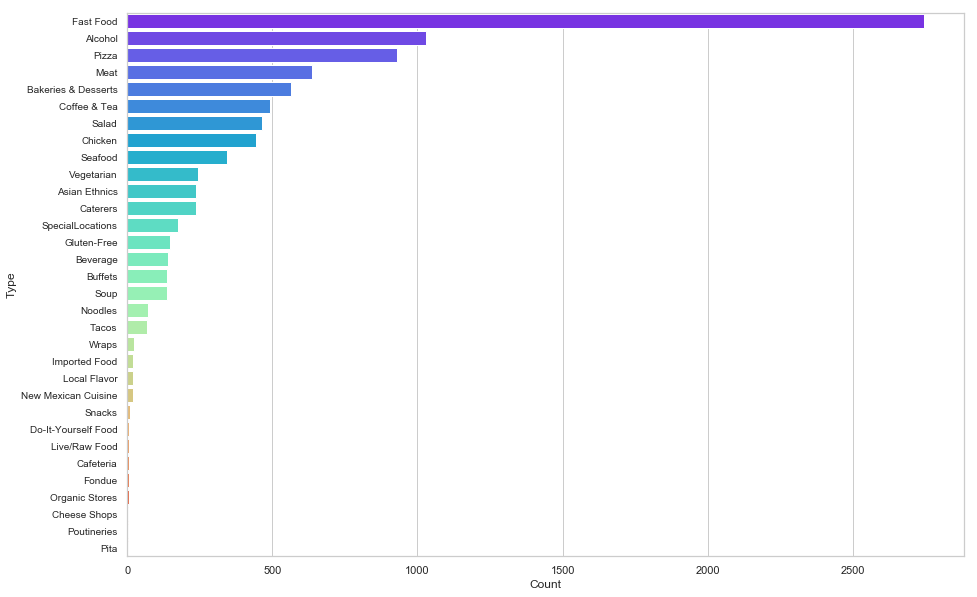

In [316]:
# Visualize dataframe types
plt.figure(figsize=(15,10))
sns.set(style='whitegrid')
types_plot = sns.barplot(x='Count', y='Type', data=type_df, palette='rainbow')
types_plot.set_yticklabels(types_plot.get_yticklabels(), fontdict={'fontsize': 10});

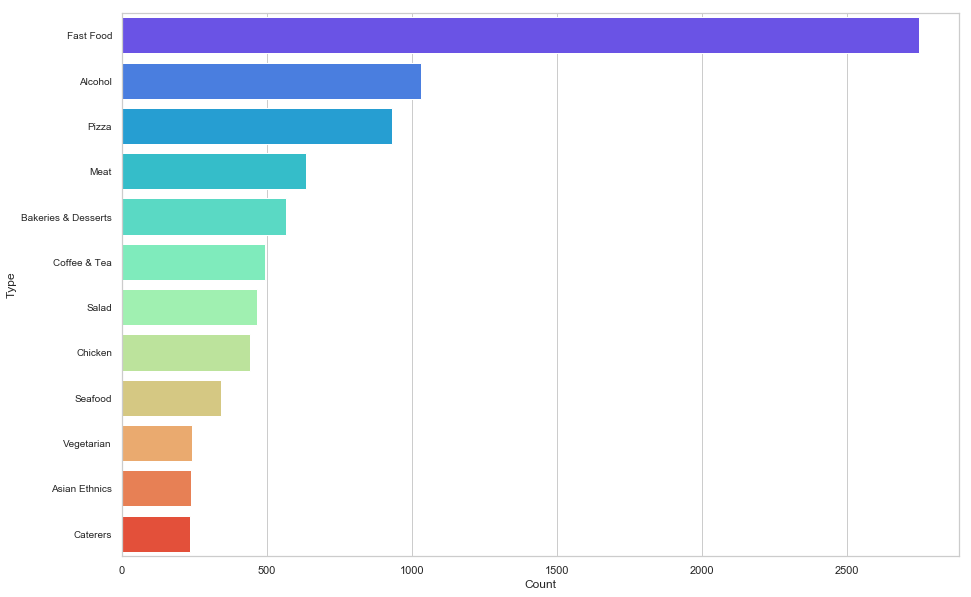

In [317]:
# Visualize dataframe types with more than 200 restaurants
plt.figure(figsize=(15,10))
sns.set(style='whitegrid')
types_plot = sns.barplot(x='Count', y='Type', data=type_df[type_df['Count'] > 200], palette='rainbow')
types_plot.set_yticklabels(types_plot.get_yticklabels(), fontdict={'fontsize': 10});

## Time of the Day

In [518]:
time = ['Bed & Breakfast', 'Breakfast & Brunch', 'Dinner Theater', 'Nightlife']

In [519]:
# Create new feature time of day
business_df['time_of_day'] = business_df['categories'].apply(lambda row: [x for x in row if x in time])
business_df['time_of_day'].value_counts()

[]                                 5473
[Nightlife]                         859
[Breakfast & Brunch]                666
[Breakfast & Brunch, Nightlife]      58
[Nightlife, Breakfast & Brunch]      54
[Dinner Theater, Nightlife]           4
[Nightlife, Bed & Breakfast]          1
[Bed & Breakfast]                     1
Name: time_of_day, dtype: int64

In [520]:
def clean_time(x):
    # Check if the list is not empty
    if len(x) > 0:
        # Replace punctuation and split by space
        items =  re.sub(r'\s?[&,]', '', x[0]).split()
        
        # Append keywords
        if 'Nightlife' in items:
            items += ['Dinner', 'Latenight']
        
        # Filter unwanted words
        return [x.lower() for x in items if x not in ['Bed', 'Theater', 'Nightlife']]
    else:
        return x

In [521]:
# Process the strings
business_df['time_of_day'] = business_df['time_of_day'].apply(clean_time)

In [522]:
# Calculate the frequencies for each time of day
time = np.unique([x for row in business_df['time_of_day'] for x in row])
time_dist = dict(zip(time, [sum([x in row for row in business_df['time_of_day'] if len(row) > 0]) for x in time]))
time_df = pd.DataFrame(list(time_dist.items()), columns=['Time of Day','Count']) \
                .sort_values('Count', ascending = False) \
                .reset_index() \
                .drop('index', axis=1)

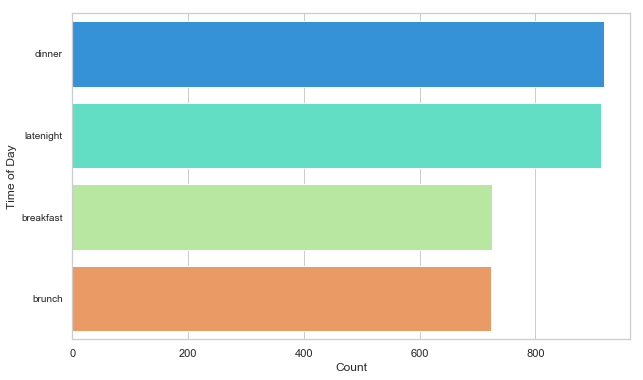

In [523]:
# Visualize dataframe types with more than 200 restaurants
plt.figure(figsize=(10,6))
sns.set(style='whitegrid')
time_plot = sns.barplot(x='Count', y='Time of Day', data=time_df, palette='rainbow')
time_plot.set_yticklabels(time_plot.get_yticklabels(), fontdict={'fontsize': 10});

## Extract Attributes Features 

In [477]:
# Convert feature attributes to a dataframe
attributes_df = business_df['attributes'].apply(pd.Series)

In [478]:
# Look at first few rows of attributes
attributes_df.head()

,RestaurantsTableService,GoodForMeal,Alcohol,Caters,HasTV,RestaurantsGoodForGroups,NoiseLevel,WiFi,RestaurantsAttire,RestaurantsReservations,...,GoodForDancing,Music,BestNights,CoatCheck,Smoking,ByAppointmentOnly,RestaurantsCounterService,AgesAllowed,AcceptsInsurance,HairSpecializesIn
0,False,"{'dessert': False, 'latenight': False, 'lunch'...",none,False,True,True,loud,free,casual,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,"{'dessert': False, 'latenight': True, 'lunch':...",none,False,False,True,loud,paid,casual,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [479]:
# Check missing values
attributes_df.isna().sum().sort_values(ascending=False)

HairSpecializesIn             7114
AcceptsInsurance              7111
AgesAllowed                   7103
DietaryRestrictions           7085
Open24Hours                   7033
RestaurantsCounterService     6994
ByAppointmentOnly             6980
Corkage                       6934
BYOB                          6872
BYOBCorkage                   6712
BestNights                    6402
BusinessAcceptsBitcoin        6384
Smoking                       6356
CoatCheck                     6314
Music                         6296
GoodForDancing                6260
HappyHour                     6249
DogsAllowed                   5991
DriveThru                     5554
WheelchairAccessible          3356
Caters                        1517
NoiseLevel                    1220
WiFi                          1108
RestaurantsTableService       1106
Alcohol                        948
BusinessParking                810
BikeParking                    780
Ambience                       754
HasTV               

In [480]:
# Identify attributes that has too many missing values
var_to_drop = attributes_df.isna().sum()[attributes_df.isna().sum() >= attributes_df.shape[0] // 2].index
print(attributes_df.shape[0] // 2)
print(var_to_drop)

3558.0
Index(['DriveThru', 'BusinessAcceptsBitcoin', 'Open24Hours', 'BYOBCorkage',
       'BYOB', 'Corkage', 'DogsAllowed', 'DietaryRestrictions', 'HappyHour',
       'GoodForDancing', 'Music', 'BestNights', 'CoatCheck', 'Smoking',
       'ByAppointmentOnly', 'RestaurantsCounterService', 'AgesAllowed',
       'AcceptsInsurance', 'HairSpecializesIn'],
      dtype='object')


In [481]:
# Drop unnecessary variables and lowercase all column names
attributes_df = attributes_df.drop(var_to_drop, axis=1)

In [482]:
# Define name change in key-value pairs
column_name_change = {
    'RestaurantsTableService':'tableService',
    'GoodForMeal':'openFor',
    'Alcohol':'alcohol',
    'Caters':'caters',
    'HasTV':'hasTV',
    'RestaurantsGoodForGroups':'forGroups',
    'NoiseLevel':'noiceLevel',
    'WiFi':'hasWiFi',
    'RestaurantsAttire':'attire',
    'RestaurantsReservations':'reservations',
    'OutdoorSeating':'outdoorSeating',
    'BusinessAcceptsCreditCards':'acceptCreditCard',
    'RestaurantsPriceRange2':'priceRange',
    'BikeParking':'bikeParking',
    'RestaurantsDelivery':'delivery',
    'Ambience':'ambience',
    'RestaurantsTakeOut':'hasTakeOut',
    'GoodForKids':'goodForKids',
    'DriveThru':'driveThru',
    'BusinessParking':'businessParking',
    'HappyHour':'happyHour',
    'Smoking':'smoking'
}

In [483]:
# Change names for some variables
attributes_df = attributes_df.rename(columns=column_name_change)

In [484]:
# Reveal first few rows
attributes_df.head()

,tableService,openFor,alcohol,caters,hasTV,forGroups,noiceLevel,hasWiFi,attire,reservations,outdoorSeating,acceptCreditCard,priceRange,bikeParking,delivery,ambience,hasTakeOut,goodForKids,businessParking,WheelchairAccessible
0,False,"{'dessert': False, 'latenight': False, 'lunch'...",none,False,True,True,loud,free,casual,False,False,True,1.0,True,False,"{'romantic': False, 'intimate': False, 'classy...",True,True,"{'garage': False, 'street': False, 'validated'...",NaN
1,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,False,True,True,2.0,True,True,"{'romantic': False, 'intimate': False, 'classy...",True,True,"{'garage': False, 'street': False, 'validated'...",NaN
2,False,"{'dessert': False, 'latenight': True, 'lunch':...",none,False,False,True,loud,paid,casual,False,False,True,1.0,False,False,"{'romantic': False, 'intimate': False, 'classy...",True,True,"{'garage': False, 'street': False, 'validated'...",True
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
4,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,True,True,True,2.0,True,True,"{'romantic': False, 'intimate': False, 'classy...",True,True,"{'garage': False, 'street': False, 'validated'...",True


### Clean NA's For Alcohol

In [547]:
# Check number of NA's
attributes_df['alcohol'].isna().sum()

948

In [548]:
# Fill NA's
attributes_df['alcohol'] = attributes_df['alcohol'].fillna(business_df['types'].apply(lambda row: str('Alcohol' in row)))

C:\Users\Syen Yang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [549]:
# Check value counts
attributes_df['alcohol'].value_counts()

none             3405
full_bar         1896
False             903
beer_and_wine     867
True               45
Name: alcohol, dtype: int64

Now we will do some combinations: <br>
`none`, `False` -> `False` <br>
`full_bar`, `beer_and_wine`, `True` -> `True`.

In [550]:
# Combinations
attributes_df['alcohol'] = attributes_df['alcohol'].str.replace('none', 'False')
attributes_df['alcohol'] = attributes_df['alcohol'].str.replace('full_bar', 'True')
attributes_df['alcohol'] = attributes_df['alcohol'].str.replace('beer_and_wine', 'True')

In [551]:
# Convert values to boolean
attributes_df['alcohol'] = attributes_df['alcohol'].apply(lambda x: (x=='True'))

In [552]:
# Check value counts again
attributes_df['alcohol'].value_counts()

False    4308
True     2808
Name: alcohol, dtype: int64

### Break Dictionaries For Ambience and BusinessParking

In [553]:
# Break dictionary ambience
ambience_df = attributes_df['ambience'].apply(pd.Series)
ambience_df = ambience_df.drop(0,axis=1)

In [554]:
# Break dictionary businessParking
businessParking_df = attributes_df['businessParking'].apply(pd.Series)
businessParking_df = businessParking_df.drop(0,axis=1)

In [555]:
# Merge to attributes_df
attributes_df = attributes_df.merge(ambience_df, left_index=True, right_index=True)
ambience_df = ambience_df.merge(businessParking_df, left_index=True, right_index=True)

In [556]:
attributes_df = attributes_df.drop(['ambience','businessParking'], axis=1)

In [557]:
attributes_df.shape

(7116, 27)

## Final Merge And Output

In [558]:
business_df.shape

(7116, 18)

In [559]:
business_df = business_df.merge(attributes_df, left_index=True, right_index=True)

In [560]:
business_df.shape

(7116, 45)

In [561]:
business_df.head()

,attributes,business_id,categories,city,latitude,longitude,name,postal_code,review_count,stars,...,WheelchairAccessible,romantic,intimate,classy,hipster,divey,touristy,trendy,upscale,casual
0,"{'RestaurantsTableService': False, 'GoodForMea...",rDMptJYWtnMhpQu_rRXHng,"[Fast Food, Burgers, Restaurants]",Phoenix,33.607070,-112.064382,McDonald's,85022,10,1.0,...,NaN,False,False,False,False,False,False,False,False,False
1,"{'RestaurantsTableService': True, 'GoodForMeal...",1WBkAuQg81kokZIPMpn9Zg,"[Burgers, Restaurants]",Phoenix,33.607310,-112.063404,Charr An American Burger Bar,85022,232,3.0,...,NaN,False,False,False,False,False,False,False,False,True
2,"{'RestaurantsTableService': False, 'GoodForMea...",iPa__LOhse-hobC2Xmp-Kw,"[Restaurants, Burgers, Fast Food]",Phoenix,33.508765,-112.046240,McDonald's,85016,34,3.0,...,True,False,False,False,False,False,False,False,False,True
3,"{'BusinessAcceptsCreditCards': True, 'Business...",YhV93k9uiMdr3FlV4FHjwA,"[Marketing, Men's Clothing, Restaurants, Graph...",Phoenix,33.449967,-112.070222,Caviness Studio,85001,4,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",VdlPZg2NAu8t8GkdbPLecg,"[Restaurants, Gluten-Free, Indian, Seafood]",Scottsdale,33.555212,-111.900456,Tandoori Times Indian Bistro,85258,263,3.5,...,True,False,False,False,False,False,False,False,False,True
